# Notebook for Downsampling and Getting the ROI 

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import tqdm

# All the plots shown will be size 10
plt.rcParams['figure.figsize'] = (15, 15)

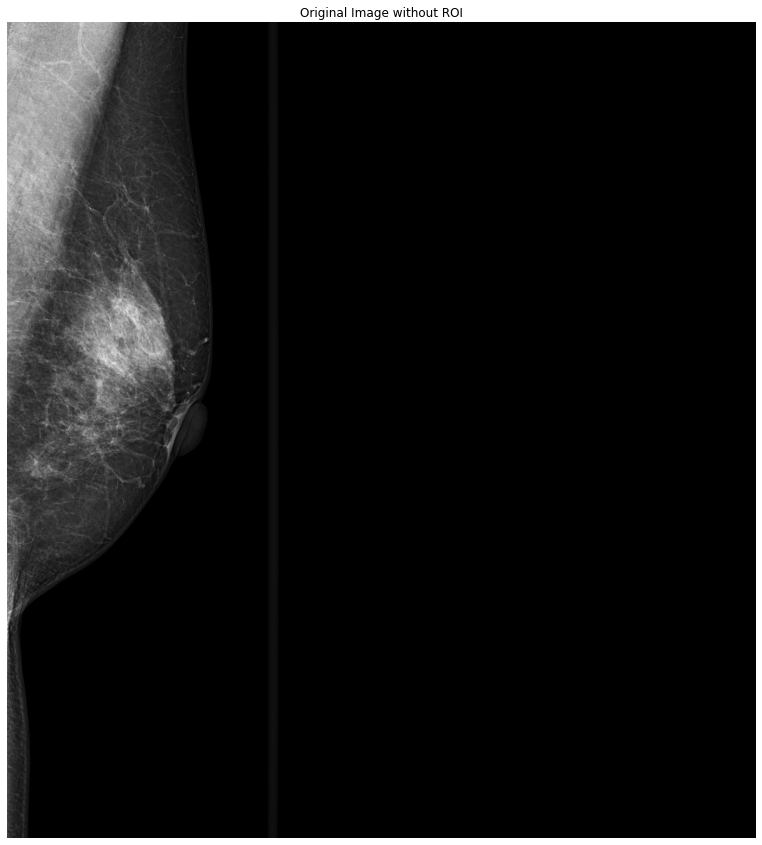

In [21]:
path = '../data/train_images_jpeg/'
# list of path of patients without ._.DS_Store and .DS_Store using glob
patients = glob.glob(path + '*')

# Get image for the first patient
image = glob.glob(patients[0] + '/*')
# Load first image with cv2
img = cv2.imread(image[0])
# Convert to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Show image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Original Image without ROI")
plt.show()

## Definition of functions to be used as ROI finders

### Non-Zero (Otsu's Method)

In [22]:
def find_ROI_non_zero(image_path):
    """
    This function uses the non-zero method to find the ROI.

    The function will be used for grayscale images from the Breast-Cancer Dataset. 

    NOTE: It uses Otsu's method to binarize the image.

    Args:
        image_path: the path to the image.

    Returns:
        The cropped and resized image. 
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
    # Find the non-zero pixels
    ys, xs = np.nonzero(bin_img)
    # Find the bounding box
    roi = img[min(ys):max(ys), min(xs):max(xs)]
    # Resize
    roi_image = cv2.resize(roi, (256, 256), interpolation=cv2.INTER_CUBIC)
    return roi, roi_image, ys, xs

image = glob.glob(patients[30] + '/*')
img = image[0]
roi, roi_image, ys, xs = find_ROI_non_zero(img)
# Put a bright and thick rectangle around the ROI in the original image
img = cv2.imread(img)
img = cv2.rectangle(img, (min(xs), min(ys)), (max(xs), max(ys)), (255, 0, 0), 20)
# Show image
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Original Image with ROI")
plt.subplot(1,2,2)
plt.imshow(roi_image, cmap='gray')
plt.axis('off')
plt.title("ROI via Otsu's method")
plt.show()


KeyboardInterrupt: 

### Binary Erode Largest Contour (BELC):

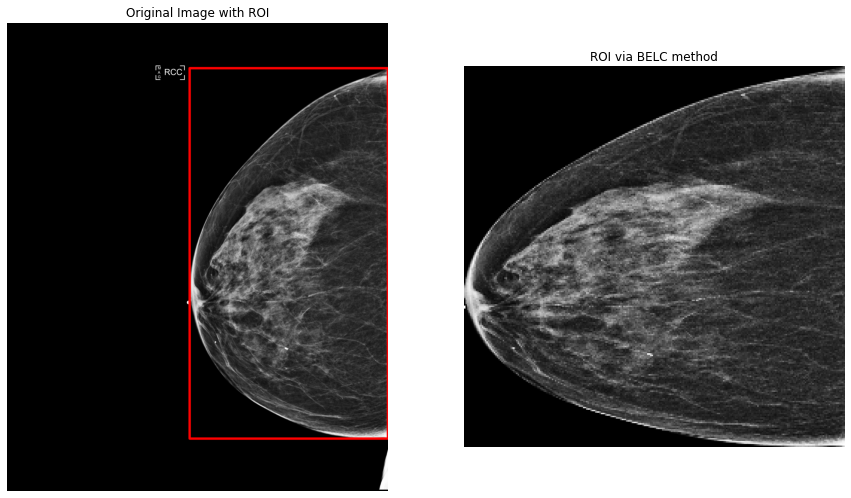

In [ ]:
def find_ROI_BELC(image_path):
    """
    This function uses the non-zero method to find the ROI.

    The function will be used for grayscale images from the Breast-Cancer Dataset. 

    NOTE: It uses Otsu's method to binarize the image.

    Args:
        image_path: the path to the image.

    Returns:
        The cropped and resized image. 
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]
    bin_img = cv2.erode(bin_img, np.ones((11,11)))
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    # Find the non-zero pixels
    xs = contour.squeeze()[:, 0]
    ys = contour.squeeze()[:, 1]
    # Find the bounding box
    roi = img[min(ys):max(ys), min(xs):max(xs)]
    # Resize
    roi_image = cv2.resize(roi, (256, 256), interpolation=cv2.INTER_CUBIC)
    return roi, roi_image, ys, xs

image = glob.glob(patients[80] + '/*')
img = image[0]
roi_2, roi_image_2, ys, xs = find_ROI_BELC(img)
# Put a bright and thick rectangle around the ROI in the original image
img = cv2.imread(img)
img = cv2.rectangle(img, (min(xs), min(ys)), (max(xs), max(ys)), (255, 0, 0), 20)
# Show image
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Original Image with ROI")
plt.subplot(1,2,2)
plt.imshow(roi_image_2, cmap='gray')
plt.axis('off')
plt.title("ROI via BELC method")
plt.show()

### Blur Binary Largest Control (BBLC)

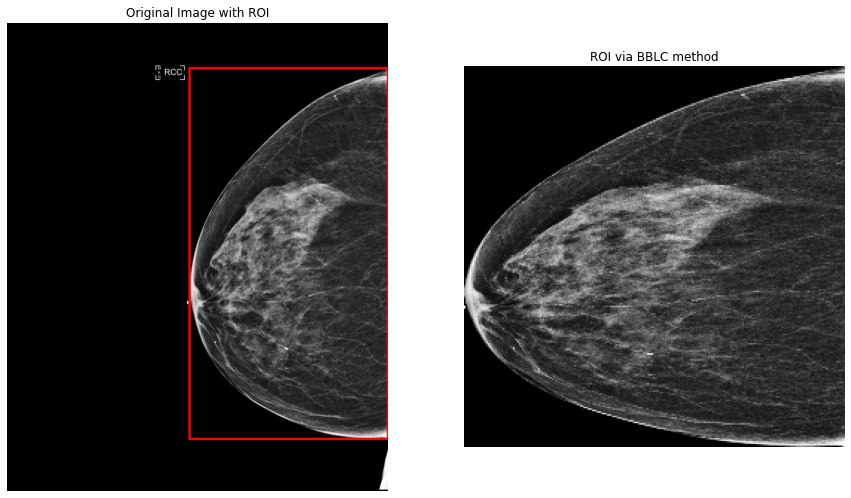

In [26]:
def find_ROI_BBLC(image_path, size = (256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Gaussian Blurring:
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    # Thresholding:
    ret, breast_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Finding Contours:
    contours, _ = cv2.findContours(breast_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find max contour:
    max_contour = max(contours, key=cv2.contourArea)
    # Find bounding box:
    x, y, w, h = cv2.boundingRect(max_contour)
    # Crop image:
    roi = img[y:y+h, x:x+w]
    # Resize
    roi_image = cv2.resize(roi, size, interpolation=cv2.INTER_CUBIC)
    return roi, roi_image, y, x, w, h

image = glob.glob(patients[80] + '/*')
img = image[0]
roi_3, roi_image_3, y, x, w, h = find_ROI_BBLC(img)
# Put a bright and thick rectangle around the ROI in the original image
img = cv2.imread(img)
img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 20)
# Show image
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Original Image with ROI")
plt.subplot(1,2,2)
plt.imshow(roi_image_3, cmap='gray')
plt.axis('off')
plt.title("ROI via BBLC method")
plt.show()

    
    

## Creating a Folder with all the images:

In [42]:
# Path to the folder with the original images in JPEG format
path = '../data/train_images_jpeg/'
if not os.path.exists('../data/256_images_cropped/'):
    os.mkdir('../data/256_images_cropped/')
else:
    print('The folder 256_images_cropped already exists.')

In [43]:
for patient in tqdm.tqdm(sorted(os.listdir(path))):
    # Loop for each patient. We need fo ignore the .DS_Store file if macOS.
     if patient != '._.DS_Store' and patient != '.DS_Store':
        # Create the folder for the jpeg images.
        if not os.path.exists('./data/256_images_cropped/' + str(patient)):
            os.mkdir('../data/256_images_cropped/' + str(patient))
        else:
            print('The folder 256_images_cropped/' + str(patient) +
                   ' already exists.')
        
        path_to_save = '../data/256_images_cropped/' + patient + '/'
        for image in sorted(os.listdir(path + str(patient))):
            # Loop for each image. We need fo ignore the .DS_Store file if macOS.
            if image != '.DS_Store':
                #if image starts with ._, then strip it.
                if image.startswith('._'):
                    image = image[2:]
                # Find the ROI
                roi, roi_image, y, x = find_ROI_BELC(path + str(patient) + '/' + str(image))
                # Save the image
                cv2.imwrite(path_to_save + str(image), roi_image)


  3%|▎         | 390/11915 [03:52<2:19:10,  1.38it/s]